In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler # методы решения проблемы несбалансированности классов

from sklearn.utils import resample # уменьшить строки с классом 1 до строк с классом 0

In [2]:
rcParams['figure.figsize'] = (10,8)

Имеется датасет, полученный в ходе исследования факторов, способных повлиять на депрессию людей, живущих в сельской местности. Задача модели ML --- научиться определять склонность к депрессии (0 --- не страдает, 1 --- страдает). Это типичная задача **бинарной классификации**. В лекции мы рассмотрим одну из популярных моделей для этой задачи --- логистическую регрессию.

## Почему логистическая регрессия --- это линейный классификатор?

Мы ещё не обсудили вопрос, почему же рассмотренная нами модель относится к **линейным моделям**. Для этого рассмотрим игрушечный пример с точками на плоскости.

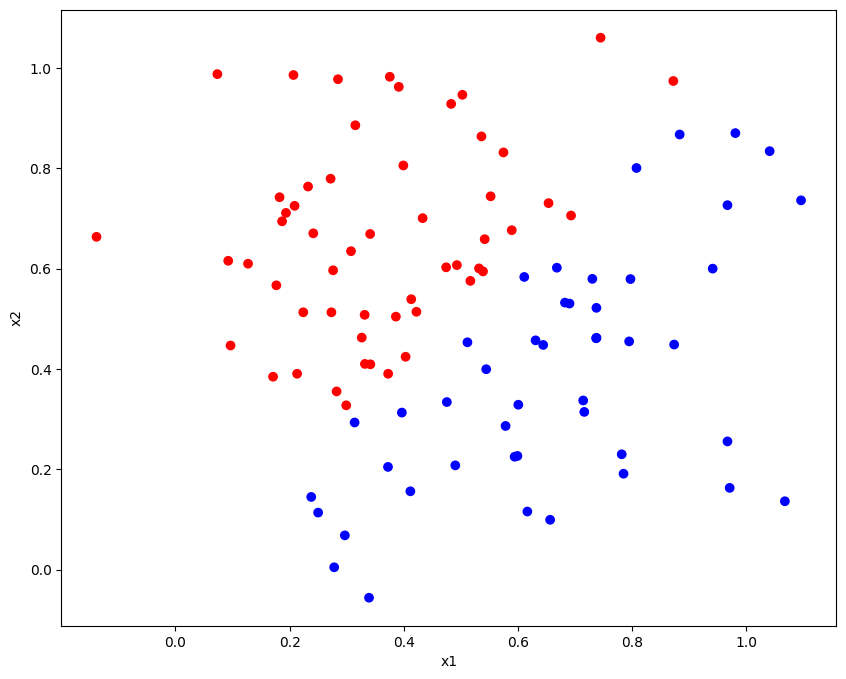

In [3]:
np.random.seed(0)
X = np.random.normal(loc=0.5, scale=0.25, size=(100, 2))
y = (X[:, 1] > X[:, 0]).astype('int') # разделяющая граница: y=x (биссектриса первой четверти)
plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in y])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [4]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

w = log_reg.coef_
bb = log_reg.intercept_

print(w, bb)

[[-3.29187849  3.02695734]] [0.23176417]


Построим разделяющую границу между классами, которую "выучила" наша модель. Для этого запишем уравнение
$$
w_1\cdot x_1 + w_2\cdot x_2 + b = 0
$$
и выразим из него $x_2$ для более привычного построения графика:
$$
x_2 = -\frac{w_1}{w_2}x_1-\frac{b}{w_2}.
$$

In [5]:
w1 = w[0][0]
w2 = w[0][1]
b = bb[0]

print('w1 = '+str(w1), '\nw2 = '+str(w2), '\nb = '+str(b))

w1 = -3.291878487299157 
w2 = 3.0269573447720246 
b = 0.23176416590409327


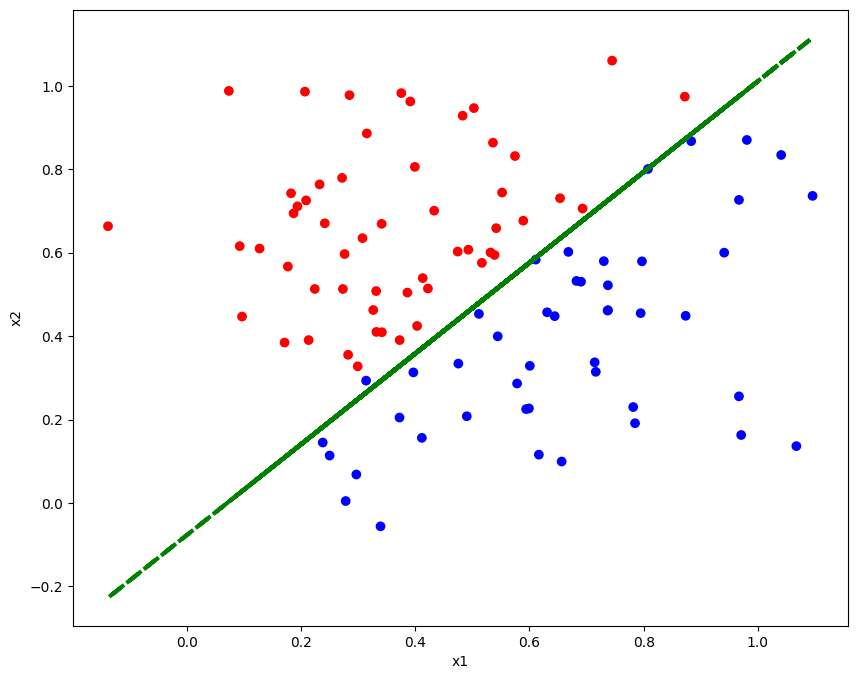

In [6]:
plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in y])
plt.plot(X[:, 0], -w1/w2*X[:, 0]-b/w2, color='green', linewidth=3, linestyle="dashed")

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Итак, модель логистической регрессии почти идеально восстановила нашу разделяющую границу. А что будет, если разделяющая граница нелинейна?

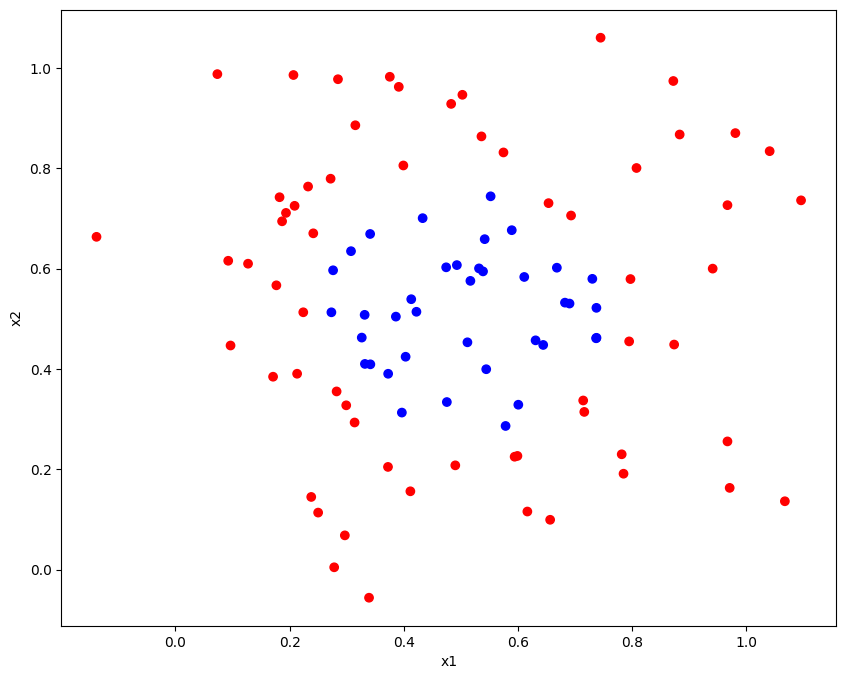

In [7]:
yy = ((X[:, 0]-0.5)**2 + (X[:, 1]-0.5)**2 > 0.25**2).astype('int')
plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in yy])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Теперь посмотрим, что выучит наша модель.

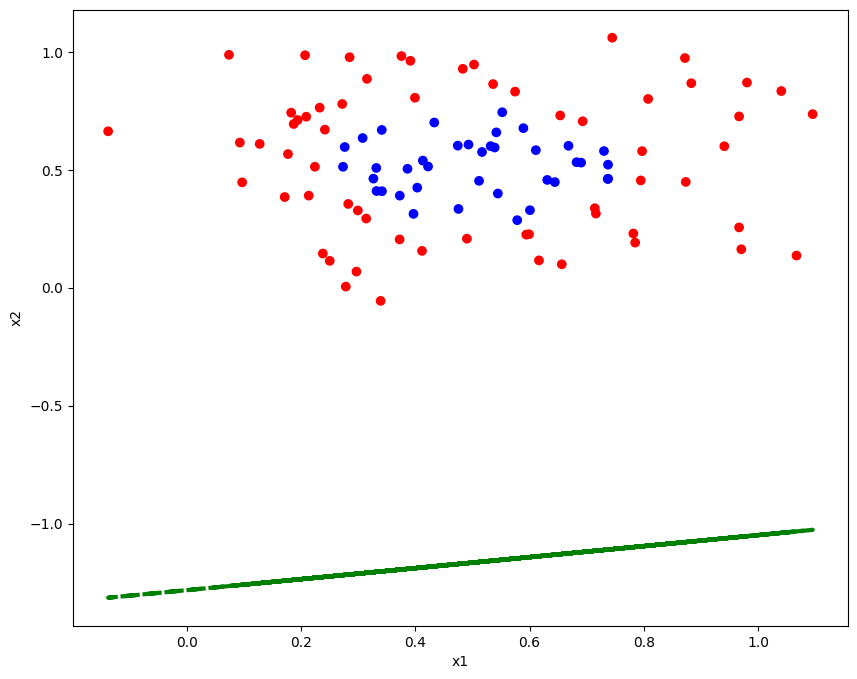

In [8]:
log_reg = LogisticRegression()
log_reg.fit(X, yy)

w1 = log_reg.coef_[0][0]
w2 = log_reg.coef_[0][1]
b = log_reg.intercept_[0]

plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in yy])
plt.plot(X[:, 0], -w1/w2*X[:, 0]-b/w2, color='green', linewidth=3, linestyle="dashed")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Как видим, несмотря на изменения в исходных данных, модель по-прежнему "учит" только линейную границу между классами, причём в данном случае далеко от идеала.

Тем не менее, в многомерных пространствах картинка получается лучше, и даже линейный классификатор способен дать хороший результат. Кроме того, мы можем использовать приём, который называется **"создание полиномиальных признаков"**. Это означает, что, помимо $x_1, x_2, \ldots, x_n$, модель также рассматривает их попарные произведения степени не выше $k$ (в случае $k=2$ это будут $x_1^2$, $x_1x_2$, $x_2^2$) в качестве признаков. Этот приём описан в [статье](https://habr.com/ru/company/ods/blog/323890/) OpenDataScience-сообщества (раздел 4). 

# Логистическая регрессия в действии

## Загрузка и препроцессинг

In [9]:
df = pd.read_csv('b_depressed.csv')
df.head()

,Survey_id,Ville_id,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
0,926,91,1,28,1,4,10,5,28912201,22861940,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1,747,57,1,23,1,3,8,5,28912201,22861940,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,1
2,1190,115,1,22,1,3,9,5,28912201,22861940,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
3,1065,97,1,27,1,2,10,4,52667108,19698904,...,0,1,0,1,22288055,18751329,0,7781123,69219765.0,0
4,806,42,0,59,0,4,10,6,82606287,17352654,...,1,0,0,0,53384566,20731006,1,20100562,43419447.0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Survey_id              1429 non-null   int64  
 1   Ville_id               1429 non-null   int64  
 2   sex                    1429 non-null   int64  
 3   Age                    1429 non-null   int64  
 4   Married                1429 non-null   int64  
 5   Number_children        1429 non-null   int64  
 6   education_level        1429 non-null   int64  
 7   total_members          1429 non-null   int64  
 8   gained_asset           1429 non-null   int64  
 9   durable_asset          1429 non-null   int64  
 10  save_asset             1429 non-null   int64  
 11  living_expenses        1429 non-null   int64  
 12  other_expenses         1429 non-null   int64  
 13  incoming_salary        1429 non-null   int64  
 14  incoming_own_farm      1429 non-null   int64  
 15  inco

In [11]:
df.nunique()

Survey_id                1429
Ville_id                  255
sex                         2
Age                        71
Married                     2
Number_children            12
education_level            18
total_members              12
gained_asset              441
durable_asset             590
save_asset                268
living_expenses           411
other_expenses            615
incoming_salary             2
incoming_own_farm           2
incoming_business           2
incoming_no_business        2
incoming_agricultural     330
farm_expenses             694
labor_primary               2
lasting_investment        982
no_lasting_investmen      939
depressed                   2
dtype: int64

Все столбцы числовые, однако данные всё ещё не готовы к построению модели. Нам необходимо:
* убрать пропуски (в столбце **no_lasting_investmen**);
* убрать лишний признак **Survey_id** (номер опроса);
* перевести категориальные признаки в бинарные (get_dummies);
* стандартизировать признаки с неудобным масштабом.

In [12]:
df.isnull().mean()

Survey_id                0.000000
Ville_id                 0.000000
sex                      0.000000
Age                      0.000000
Married                  0.000000
Number_children          0.000000
education_level          0.000000
total_members            0.000000
gained_asset             0.000000
durable_asset            0.000000
save_asset               0.000000
living_expenses          0.000000
other_expenses           0.000000
incoming_salary          0.000000
incoming_own_farm        0.000000
incoming_business        0.000000
incoming_no_business     0.000000
incoming_agricultural    0.000000
farm_expenses            0.000000
labor_primary            0.000000
lasting_investment       0.000000
no_lasting_investmen     0.013996
depressed                0.000000
dtype: float64

In [13]:
df.shape

(1429, 23)

In [14]:
# Удалим пропуски
df_1 = df.dropna()

In [15]:
df_1.shape

(1409, 23)

In [16]:
# Дропнем ненужные столбцы
df_2 = df_1.drop(['Survey_id', 'depressed'], axis=1)
df_2

,Ville_id,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,save_asset,...,other_expenses,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen
0,91,1,28,1,4,10,5,28912201,22861940,23399979,...,28203066,0,0,0,0,30028818,31363432,0,28411718,28292707.0
1,57,1,23,1,3,8,5,28912201,22861940,23399979,...,28203066,0,0,0,0,30028818,31363432,0,28411718,28292707.0
2,115,1,22,1,3,9,5,28912201,22861940,23399979,...,28203066,0,0,0,0,30028818,31363432,0,28411718,28292707.0
3,97,1,27,1,2,10,4,52667108,19698904,49647648,...,44042267,0,1,0,1,22288055,18751329,0,7781123,69219765.0
4,42,0,59,0,4,10,6,82606287,17352654,23399979,...,74503502,1,0,0,0,53384566,20731006,1,20100562,43419447.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,22,1,25,1,1,7,5,28912201,22861940,23399979,...,28203066,0,0,0,0,30028818,31363432,0,28411718,28292707.0
1425,69,1,28,1,4,10,6,15711078,24023054,15506558,...,71588707,0,1,0,0,23022095,1021536,0,1823477,47384361.0
1426,184,1,66,0,0,1,1,42440731,22861940,22562605,...,56534257,0,1,0,0,12545373,10454478,0,46444572,10454478.0
1427,75,1,51,1,1,12,5,28912201,22861940,23399979,...,28203066,0,0,0,0,30028818,31363432,0,28411718,28292707.0


In [17]:
# Переведём признаки "Номер виллы" и "Уровень образования" в бинарные 
# * мы не уверены на 100 %, что уровень образования ранговый, поэтому считаем его категориальным
# с осторожностью
df_3 = pd.get_dummies(df_2, columns=['Ville_id', 'education_level'])

In [18]:
df_3.shape

(1409, 292)

In [19]:
# Масштабирование
col_names = df.columns.values # это имена всех столбцов
large_numbers = [col for col in col_names if df[col].mean() > 10000] # имена тех, у кого среднее > 10000

# нормализация
scaler = StandardScaler()
X_st = scaler.fit_transform(df_3[large_numbers])

# Переприсвоим старым колонкам новые
df_3[large_numbers] = X_st

df_3.head()

,sex,Age,Married,Number_children,total_members,gained_asset,durable_asset,save_asset,living_expenses,other_expenses,...,education_level_9,education_level_10,education_level_11,education_level_12,education_level_13,education_level_14,education_level_16,education_level_17,education_level_18,education_level_19
0,1,28,1,4,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,True,False,False,False,False,False,False,False,False
1,1,23,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,False
2,1,22,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,True,False,False,False,False,False,False,False,False,False
3,1,27,1,2,4,0.949678,-0.408733,1.248573,-1.527659,0.482377,...,False,True,False,False,False,False,False,False,False,False
4,0,59,0,4,6,2.441322,-0.538818,-0.227442,2.303754,1.893300,...,False,True,False,False,False,False,False,False,False,False


## Построение модели и валидация

In [20]:
X = df_3
y = df_1['depressed']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
log_reg = LogisticRegression(max_iter=500) # Увеличивая max_iter, мы даём алгоритму больше времени на поиск оптимального решения
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_valid)

print(accuracy_score(y_valid, y_pred)) # точность

0.8297872340425532


## Метрики на основе confusion matrix

Разберёмся, так ли хороша наша модель, как кажется (accuracy=83.9 %). Для начала посмотрим на соотношение классов в задаче.

In [22]:
y.value_counts(normalize=True)

depressed
0    0.833215
1    0.166785
Name: proportion, dtype: float64

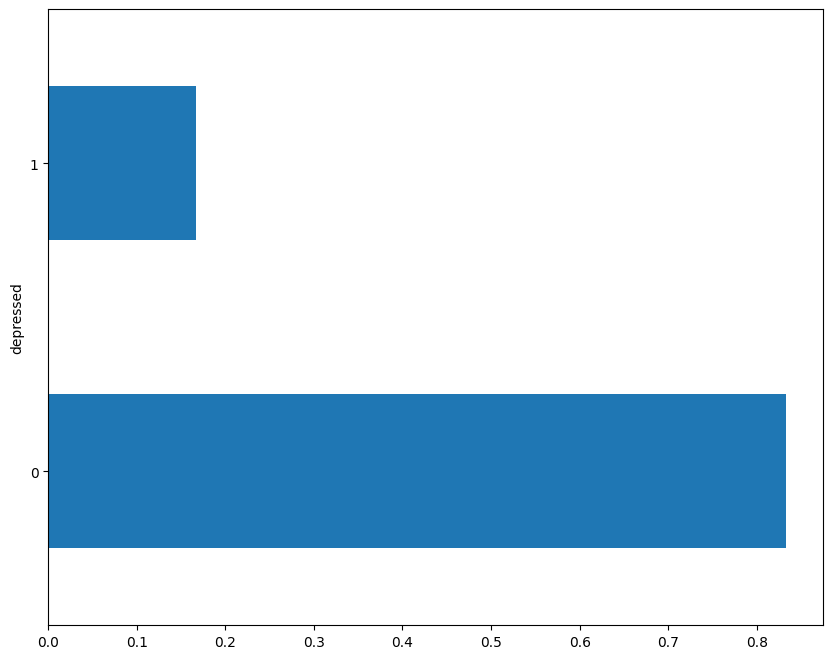

In [23]:
y.value_counts(normalize=True).plot(kind='barh')
plt.show()

Мы видим, что объектов класса 0 в выборке значительно больше (83.3 %), чем объектов класса 1. Если бы мы решили построить константный классификатор, который предсказывает 0 ВСЕГДА, то accuracy такого классификатора была бы примерно 83.3 %. Из этого можно сделать вывод, что accuracy --- далеко не лучший выбор метрики качества для случая несбалансированных классов.

Какие же есть альтернативы? Прежде всего, это матрица ошибок (confusion_matrix). В ней по строкам расположены истинные значения классов, а по столбцам --- предсказанные моделью. 

В идеальном случае данная матрица содержит нули вне главной диагонали. На практике же, в зависимости от задачи, мы бы хотели **минимизировать** значения $FN$ либо $FP$. К примеру, в задаче обнаружения спама нам бы не хотелось, чтобы модель помечала как спам нормальные письма, т. е. хотим как можно меньше **ложных срабатываний** (False Positive). В задаче же медицинской диагностики куда важнее не пропустить больных (т. е. нужно минимизировать **пропуски класса 1**, False Negative).

Построим такую матрицу в нашей задаче обнаружения склонности к депрессии.

In [24]:
print(confusion_matrix(y_valid, y_pred))

[[348   7]
 [ 65   3]]


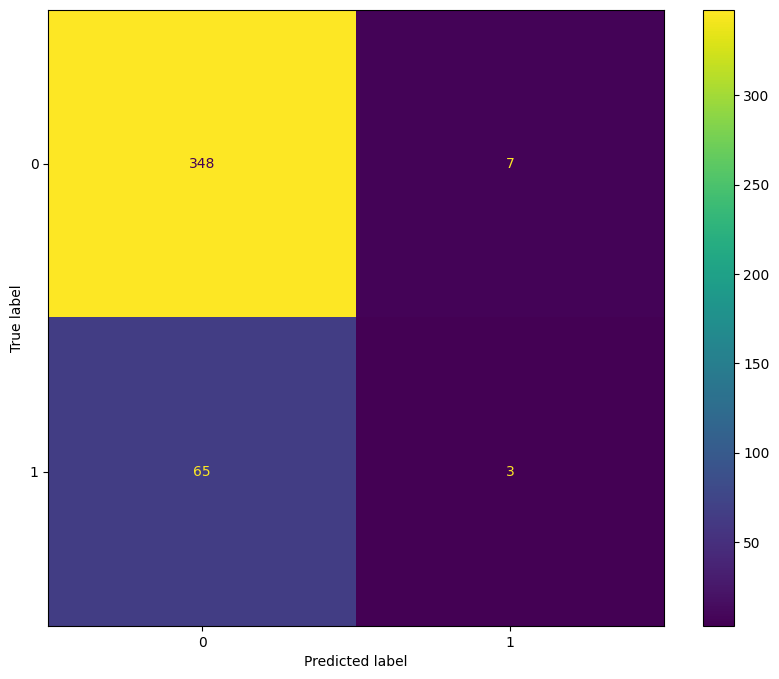

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred))
disp.plot()

Итак, наша модель определяет 4 человек как склонных к депрессии (в то время как они "здоровы"), а также 50 человек помечает "здоровыми", в то время как они склонны к депрессии. Последнее обстоятельство явно не очень хорошо. Ведь всего у нас было 52 случая склонности к депрессии, из которых модель сумела найти только два!

### Точность, полнота и F-мера

In [26]:
print('Precision:', precision_score(y_valid, y_pred))
print('Recall:', recall_score(y_valid, y_pred))
print('F1 score:', f1_score(y_valid, y_pred))

Precision: 0.3
Recall: 0.04411764705882353
F1 score: 0.07692307692307693


## Настройка гиперпараметров логистической регрессии по f1_score

Попробуем настроить параметр C (силу регуляризации) для каждого типа регуляризации.

### Регуляризация L2 (по умолчанию)

In [27]:
np.round(np.logspace(-3, 3, 10), 6)

array([1.00000000e-03, 4.64200000e-03, 2.15440000e-02, 1.00000000e-01,
       4.64159000e-01, 2.15443500e+00, 1.00000000e+01, 4.64158880e+01,
       2.15443469e+02, 1.00000000e+03])

In [28]:
log_reg = LogisticRegression(solver='liblinear') # для небольших и средних наборов данных

C_values = {'C': np.logspace(-3, 3, 10)} # регуляризация, l2
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='f1')

In [29]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 1000.0}
0.2013484144026016


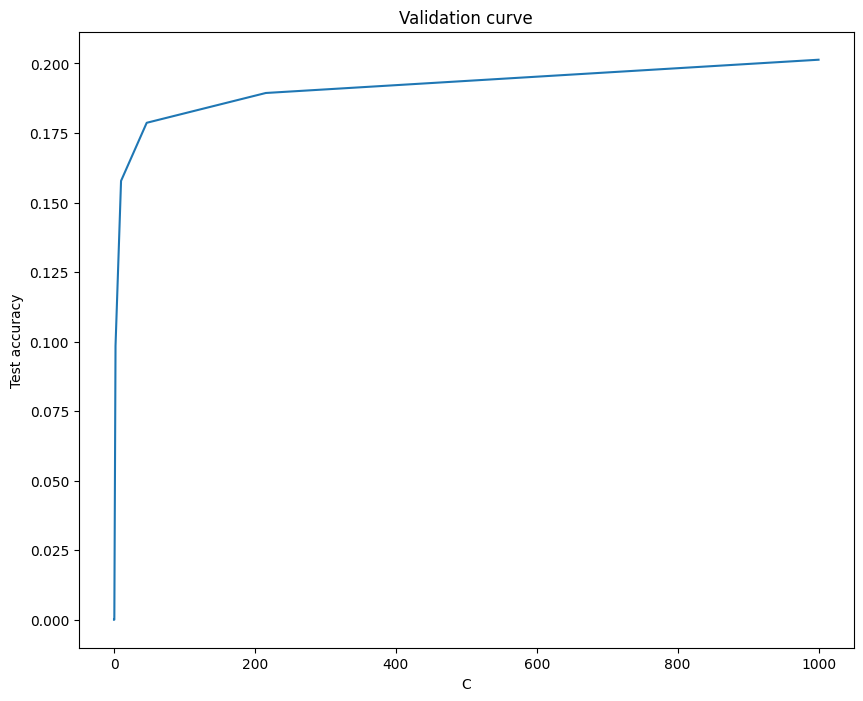

In [30]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

### Регуляризация L1

In [31]:
log_reg = LogisticRegression(solver='liblinear', penalty='l1')

C_values = {'C': np.logspace(-3, 3, 10)} # для l1
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='f1')

In [32]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 1000.0}
0.19795373890266293


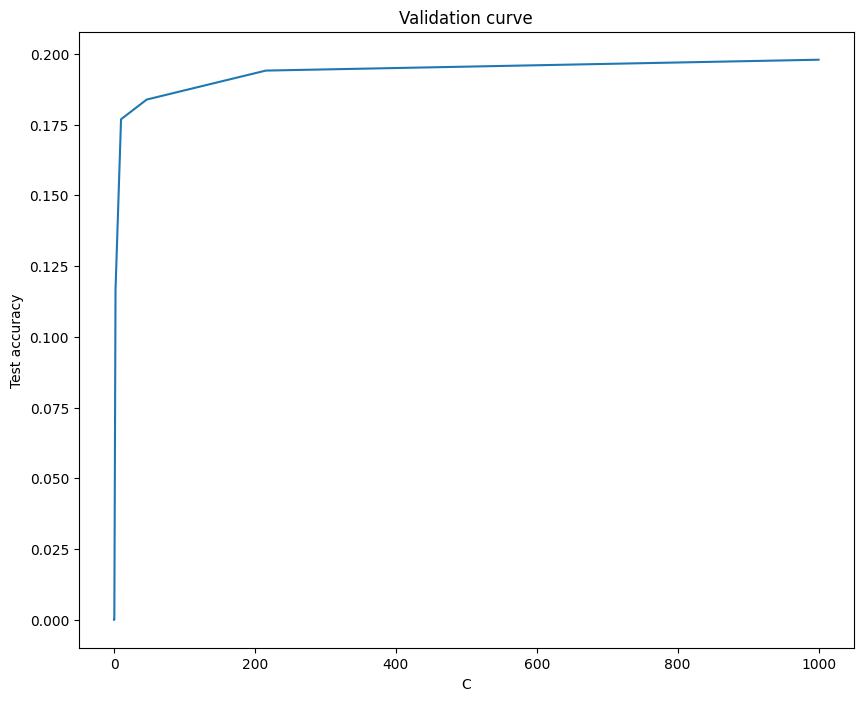

In [33]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

In [34]:
y_pred = logreg_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[320  35]
 [ 57  11]]
F1 score valid: 0.19298245614035087


Стала ли наша модель лучше? Однозначно сказать трудно :)

Однако уже понятно, что модель недообучена (слабый результат на train + слабый результат на valid). Возможно, в неё стоит добавить полиномиальные фичи. Но тогда возникнет проблема: число признаков больше числа объектов. Другая возможная причина: у нас просто мало данных (всего около 1400 объектов).

# Попытки улучшить модель

In [35]:
# kNN (не помог)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[340  15]
 [ 64   4]]
F1 score valid: 0.09195402298850575


In [36]:
knn_params = {'n_neighbors': np.arange(1, 50, 2)}
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='f1')
knn_grid.fit(X_train, y_train)

y_pred = knn_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[297  58]
 [ 58  10]]
F1 score valid: 0.14705882352941177


In [37]:
rf = DecisionTreeClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[306  49]
 [ 54  14]]
F1 score valid: 0.21374045801526717


RandomOverSampler - это метод переизбыточной выборки меньшинства, который помогает решить проблему несбалансированности классов путем случайного дублирования образцов меньшинства. 

In [38]:
# Искусственное добавление объектов класса 1
ros = RandomOverSampler(sampling_strategy='minority')
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [39]:
# Проверим баланс
y_ros.value_counts()

depressed
0    819
1    819
Name: count, dtype: int64

In [40]:
# Логистическая регрессия с добавлением класса 1
logreg_ros = LogisticRegression(solver='liblinear')
logreg_ros.fit(X_ros, y_ros)
y_pred = logreg_ros.predict(X_valid)

print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[248 107]
 [ 43  25]]
F1 score valid: 0.25


In [41]:
# Подбор гиперпараметров
logreg_params = {'C': np.logspace(-3, 3, 10), 'penalty': ['l2', 'l1']}
logreg_grid = GridSearchCV(logreg_ros, logreg_params, cv=5, scoring='f1')
logreg_grid.fit(X_ros, y_ros)

y_pred = logreg_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[247 108]
 [ 45  23]]
F1 score valid: 0.23115577889447236


# Обрезка набора данных

In [42]:
X = df_3
y = df_1['depressed']

In [43]:
X.shape

(1409, 292)

In [44]:
short_data = X
short_data['target'] = y

In [45]:
short_data_class_0  = short_data[short_data['target'] == 0]
short_data_class_0

,sex,Age,Married,Number_children,total_members,gained_asset,durable_asset,save_asset,living_expenses,other_expenses,...,education_level_10,education_level_11,education_level_12,education_level_13,education_level_14,education_level_16,education_level_17,education_level_18,education_level_19,target
0,1,28,1,4,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,True,False,False,False,False,False,False,False,False,0
2,1,22,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,0
3,1,27,1,2,4,0.949678,-0.408733,1.248573,-1.527659,0.482377,...,True,False,False,False,False,False,False,False,False,0
4,0,59,0,4,6,2.441322,-0.538818,-0.227442,2.303754,1.893300,...,True,False,False,False,False,False,False,False,False,0
5,1,35,1,6,8,0.116165,-1.460065,-0.227442,-0.085240,-1.023497,...,True,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,1,25,1,3,5,-0.461482,-0.562348,0.642398,2.151265,-1.542541,...,False,False,False,False,False,False,False,False,False,0
1424,1,25,1,1,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,0
1425,1,28,1,4,6,-0.891563,-0.168987,-0.671321,-1.047826,1.758291,...,True,False,False,False,False,False,False,False,False,0
1427,1,51,1,1,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,True,False,False,False,False,False,False,0


In [46]:
short_data_class_1  = short_data[short_data['target'] == 1]
short_data_class_1

,sex,Age,Married,Number_children,total_members,gained_asset,durable_asset,save_asset,living_expenses,other_expenses,...,education_level_10,education_level_11,education_level_12,education_level_13,education_level_14,education_level_16,education_level_17,education_level_18,education_level_19,target
1,1,23,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
6,0,34,0,1,3,0.383497,-0.285308,-0.227442,1.630261,-1.053169,...,False,False,False,False,False,False,False,False,False,1
10,1,84,0,0,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
14,1,56,1,0,2,2.988875,-0.328818,-1.210093,0.099018,1.799090,...,False,False,True,False,False,False,False,False,False,1
20,1,40,0,0,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,1,28,1,4,6,-0.174228,-0.233363,-0.720307,2.901003,0.308052,...,False,False,True,False,False,False,False,False,False,1
1396,1,49,1,2,4,-1.043967,-0.233363,-1.435590,-0.186899,-0.560607,...,False,False,False,False,False,False,False,False,False,1
1407,1,59,0,0,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
1415,1,34,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,True,False,False,False,False,False,False,False,False,1


In [47]:
short_data_class_0
short_data_class_1

,sex,Age,Married,Number_children,total_members,gained_asset,durable_asset,save_asset,living_expenses,other_expenses,...,education_level_10,education_level_11,education_level_12,education_level_13,education_level_14,education_level_16,education_level_17,education_level_18,education_level_19,target
1,1,23,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
6,0,34,0,1,3,0.383497,-0.285308,-0.227442,1.630261,-1.053169,...,False,False,False,False,False,False,False,False,False,1
10,1,84,0,0,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
14,1,56,1,0,2,2.988875,-0.328818,-1.210093,0.099018,1.799090,...,False,False,True,False,False,False,False,False,False,1
20,1,40,0,0,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,1,28,1,4,6,-0.174228,-0.233363,-0.720307,2.901003,0.308052,...,False,False,True,False,False,False,False,False,False,1
1396,1,49,1,2,4,-1.043967,-0.233363,-1.435590,-0.186899,-0.560607,...,False,False,False,False,False,False,False,False,False,1
1407,1,59,0,0,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,1
1415,1,34,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,True,False,False,False,False,False,False,False,False,1


In [48]:
class_0_resample = resample(short_data_class_0, replace=True, n_samples=len(short_data_class_1))
class_0_resample

,sex,Age,Married,Number_children,total_members,gained_asset,durable_asset,save_asset,living_expenses,other_expenses,...,education_level_10,education_level_11,education_level_12,education_level_13,education_level_14,education_level_16,education_level_17,education_level_18,education_level_19,target
1409,1,33,1,4,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,True,False,False,False,False,False,False,False,False,0
763,1,30,1,0,2,-0.233851,-0.922856,-0.227442,1.693799,-1.523477,...,False,False,False,False,False,False,False,False,False,0
679,1,46,0,0,1,-1.654949,1.917694,-0.227442,1.223624,-0.800954,...,False,False,True,False,False,False,False,False,False,0
419,1,22,1,2,4,1.433329,0.124036,-1.453258,1.947947,-1.303975,...,False,True,False,False,False,False,False,False,False,0
576,1,41,0,5,8,2.029757,1.336087,1.158512,-0.809562,-1.343736,...,False,False,False,False,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,1,59,1,0,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,False,False,False,False,False,False,False,False,False,0
227,1,31,1,4,6,-0.851198,-0.608522,-0.227442,0.359520,0.382233,...,False,False,False,False,False,False,False,False,False,0
998,1,23,1,3,5,-0.441242,0.508518,-0.227442,2.901003,-0.125907,...,False,False,False,False,False,False,False,False,False,0
147,1,23,0,3,4,-0.645416,-0.044674,-0.227442,0.041834,-0.960443,...,False,False,False,False,False,False,False,False,False,0


In [49]:
short_data = pd.concat([class_0_resample, short_data_class_1])
short_data.shape

(470, 293)

In [50]:
short_data['target'].value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [51]:
X_short = short_data.drop(columns=['target'])
y_short = short_data['target']

X_train_short, X_valid_short, y_train_short, y_valid_short = train_test_split(X_short, y_short, test_size=0.25, random_state=0)

In [52]:
# Логистическая регрессия short data
logreg_ros = LogisticRegression(solver='liblinear')
logreg_ros.fit(X_train_short, y_train_short)
y_pred_short = logreg_ros.predict(X_valid_short)

print(confusion_matrix(y_valid_short, y_pred_short))
print('F1 score valid:', f1_score(y_valid_short, y_pred_short))
print('Accuracy score valid:', accuracy_score(y_valid_short, y_pred_short))

[[38 21]
 [33 26]]
F1 score valid: 0.49056603773584906
Accuracy score valid: 0.5423728813559322


In [53]:
# Логистическая регрессия short data
logreg_ros = LogisticRegression(max_iter=500)
logreg_ros.fit(X_train_short, y_train_short)
y_pred_short = logreg_ros.predict(X_valid_short)

print(confusion_matrix(y_valid_short, y_pred_short))
print('F1 score valid:', f1_score(y_valid_short, y_pred_short))
print('Accuracy score valid:', accuracy_score(y_valid_short, y_pred_short))

[[37 22]
 [32 27]]
F1 score valid: 0.5
Accuracy score valid: 0.5423728813559322


In [54]:
# Подбор гиперпараметров
logreg_params = {'C': [0.001, 0.01, 0.02, 0.03, 0.1, 1, 10, 50, 1000], 'penalty': ['l2', 'l1']}
logreg_ros = LogisticRegression(solver='liblinear')
logreg_grid = GridSearchCV(logreg_ros, logreg_params, cv=5, scoring='f1')
logreg_grid.fit(X_train_short, y_train_short)

y_pred_short_log = logreg_grid.best_estimator_.predict(X_valid_short)
print(confusion_matrix(y_valid_short, y_pred_short_log))
print('best_estimator:', logreg_grid.best_params_)
print('F1 score valid:', f1_score(y_valid_short, y_pred_short_log))

[[ 0 59]
 [ 0 59]]
best_estimator: {'C': 0.01, 'penalty': 'l1'}
F1 score valid: 0.6666666666666666


In [55]:
# kNN 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_short, y_train_short)

y_pred_short_knn = knn.predict(X_valid_short)
print(confusion_matrix(y_valid_short, y_pred_short_knn))
print('F1 score valid:', f1_score(y_valid_short, y_pred_short_knn))

[[31 28]
 [35 24]]
F1 score valid: 0.43243243243243246


In [56]:
knn_params = {'n_neighbors': np.arange(1, 50, 2)}
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='f1')
knn_grid.fit(X_train_short, y_train_short)

y_pred_short_cv_knn = knn_grid.best_estimator_.predict(X_valid_short)
print(confusion_matrix(y_valid_short, y_pred_short_cv_knn))
print('F1 score valid:', f1_score(y_valid_short, y_pred_short_cv_knn))

[[35 24]
 [32 27]]
F1 score valid: 0.4909090909090909


In [57]:
dt = DecisionTreeClassifier()
dt.fit(X_train_short, y_train_short)

y_pred_short_dt = dt.predict(X_valid_short)
print(confusion_matrix(y_valid_short, y_pred_short_dt))
print('F1 score valid:', f1_score(y_valid_short, y_pred_short_dt))

[[33 26]
 [25 34]]
F1 score valid: 0.5714285714285714


# Дополнительная предобработка

Очень распространенным способом описания данных является корреляционная матрица. это наглядный метод, позволяющий показать взаимосвязь между переменными в наборе данных. Значения корреляции обычно находятся в диапазоне от -1 до +1. Однако на практике, в целом, элементы имеют положительные корреляции.

In [58]:
data_pd = df.copy()

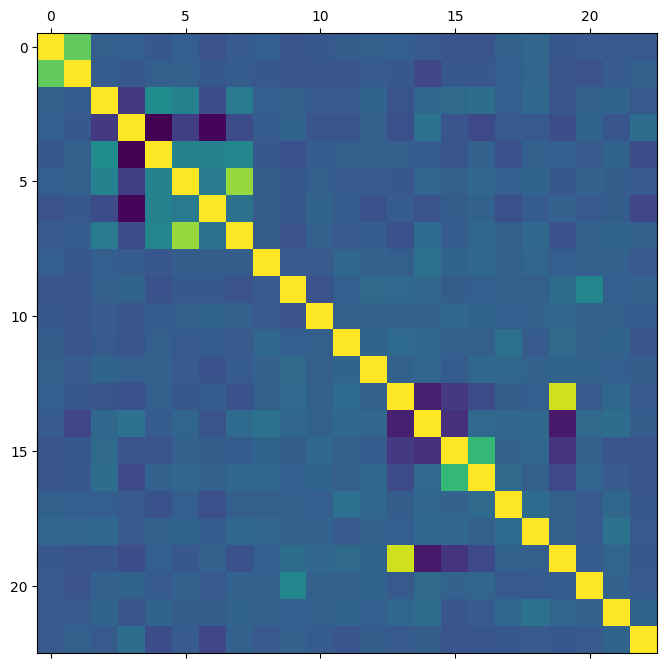

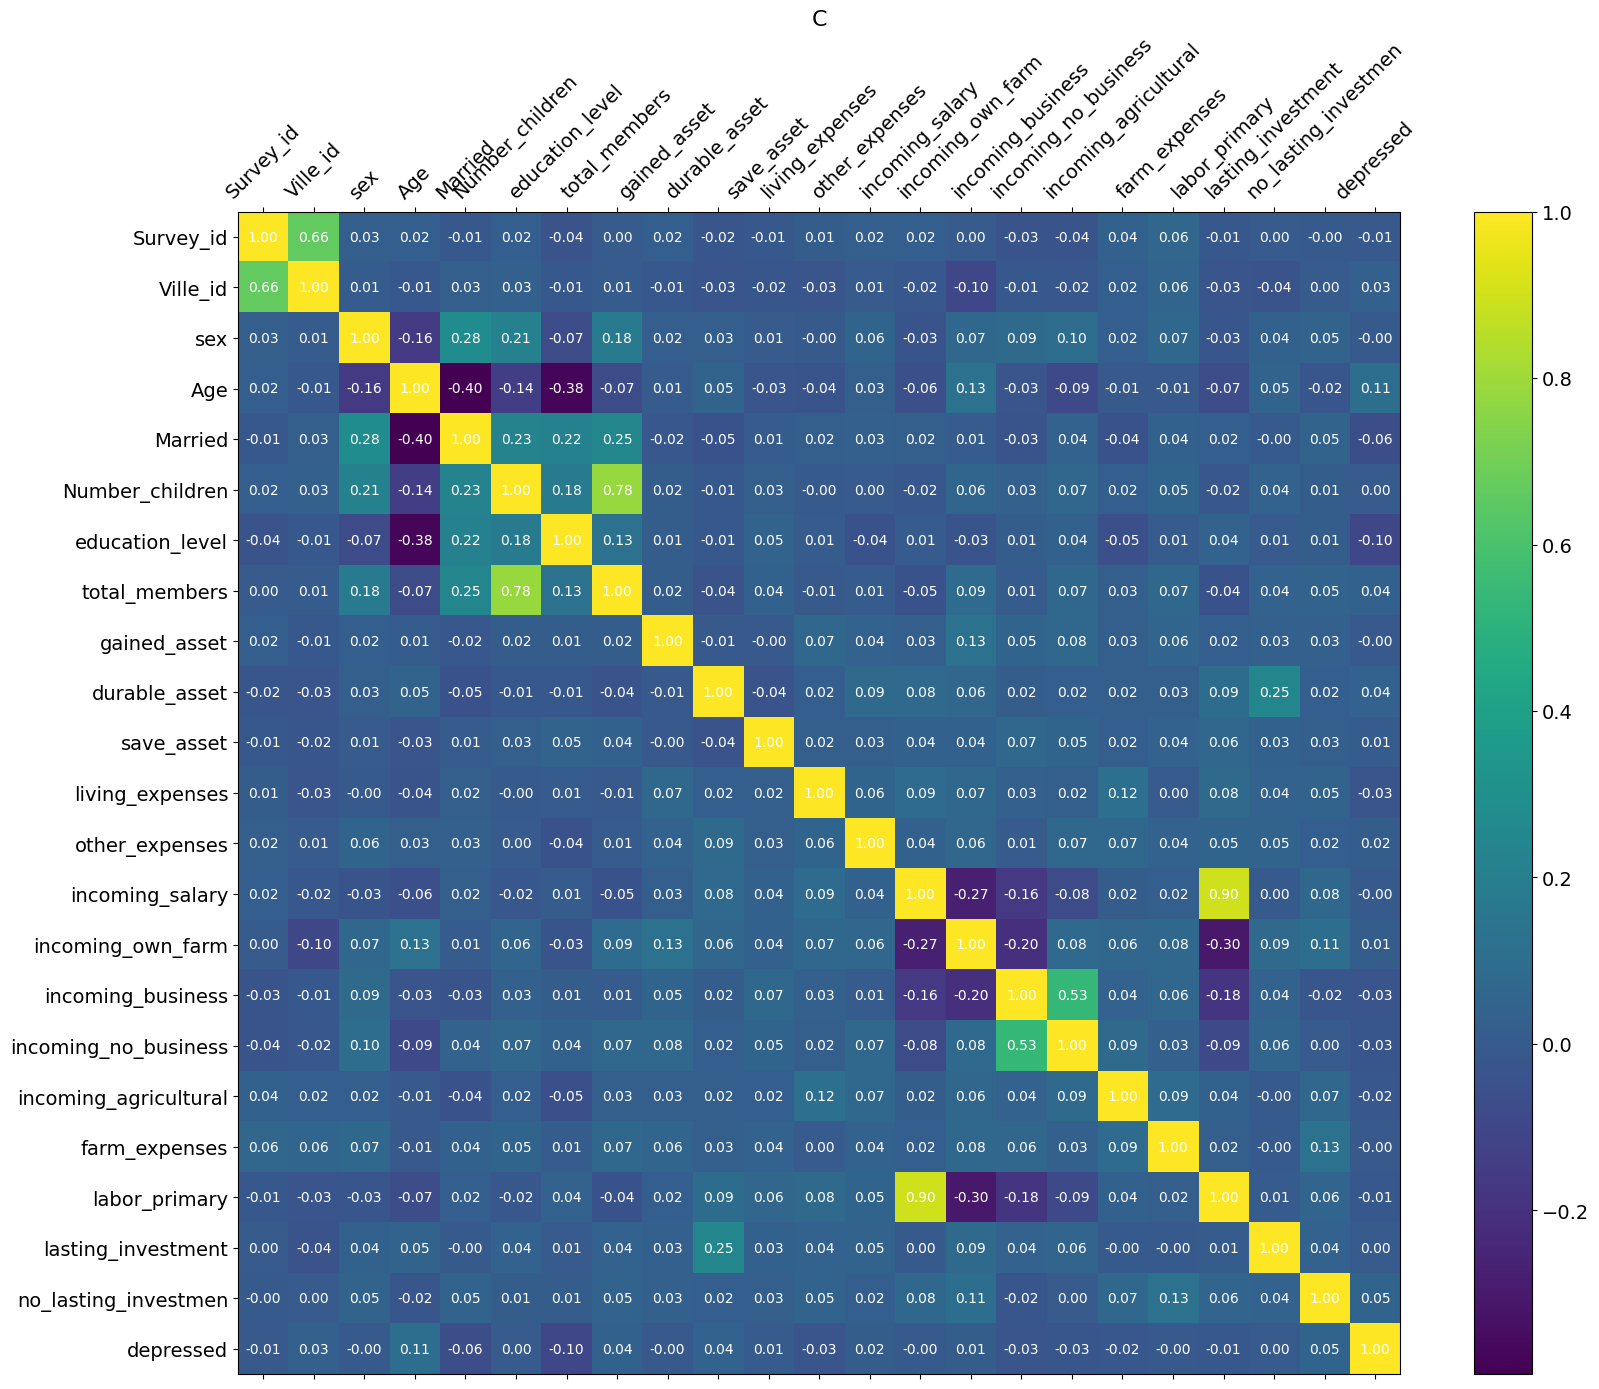

In [59]:
plt.matshow(data_pd.corr())
plt.show()

f = plt.figure(figsize=(19, 15))
corr_matrix = data_pd.corr()
plt.matshow(corr_matrix, fignum=f.number)


for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="white" if abs(corr_matrix.iloc[i, j]) > 0.7 else "white")

plt.xticks(range(data_pd.shape[1]), data_pd.columns, fontsize=14, rotation=45)
plt.yticks(range(data_pd.shape[1]), data_pd.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('C',fontsize=16);

In [60]:
data_pd.columns

Index(['Survey_id', 'Ville_id', 'sex', 'Age', 'Married', 'Number_children',
       'education_level', 'total_members', 'gained_asset', 'durable_asset',
       'save_asset', 'living_expenses', 'other_expenses', 'incoming_salary',
       'incoming_own_farm', 'incoming_business', 'incoming_no_business',
       'incoming_agricultural', 'farm_expenses', 'labor_primary',
       'lasting_investment', 'no_lasting_investmen', 'depressed'],
      dtype='object')

In [61]:
data_pd.drop(columns=['Survey_id'])

,Ville_id,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,save_asset,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
0,91,1,28,1,4,10,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1,57,1,23,1,3,8,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,1
2,115,1,22,1,3,9,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
3,97,1,27,1,2,10,4,52667108,19698904,49647648,...,0,1,0,1,22288055,18751329,0,7781123,69219765.0,0
4,42,0,59,0,4,10,6,82606287,17352654,23399979,...,1,0,0,0,53384566,20731006,1,20100562,43419447.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,22,1,25,1,1,7,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1425,69,1,28,1,4,10,6,15711078,24023054,15506558,...,0,1,0,0,23022095,1021536,0,1823477,47384361.0,0
1426,184,1,66,0,0,1,1,42440731,22861940,22562605,...,0,1,0,0,12545373,10454478,0,46444572,10454478.0,1
1427,75,1,51,1,1,12,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0


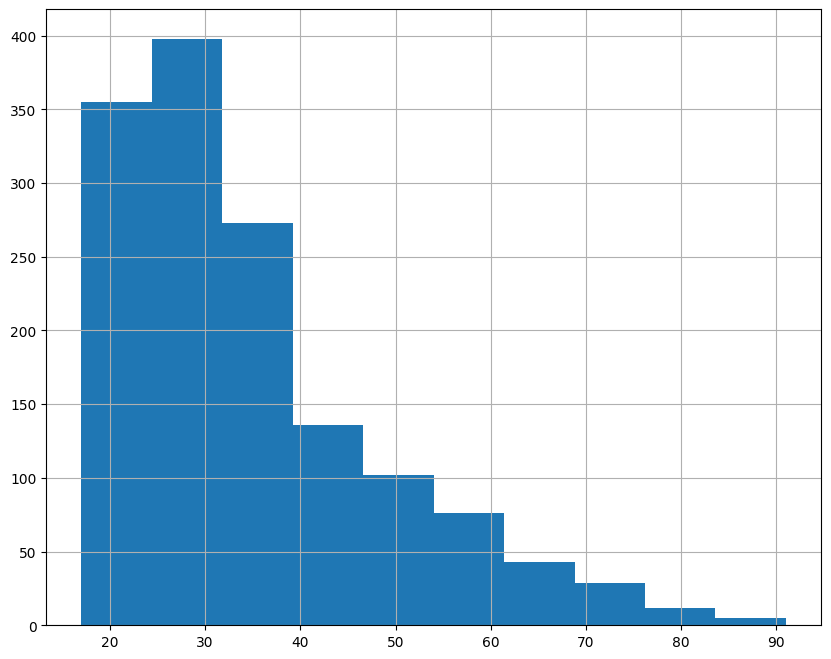

In [62]:
hist = data_pd['Age'].hist()

На приведенном выше рисунке показаны основные возрастные группы, где наиболее часто встречается значение age = 30, умноженное на 400.

<Axes: xlabel='sex', ylabel='count'>

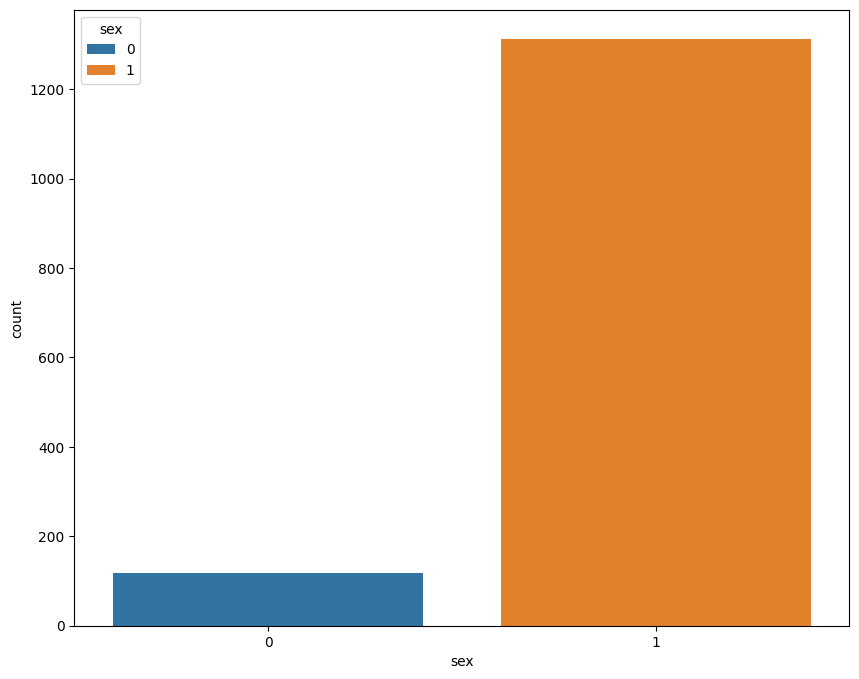

In [63]:
import seaborn as sns
sns.countplot(x='sex', hue='sex', data = data_pd) 
# Where woman is 1 and man is 0

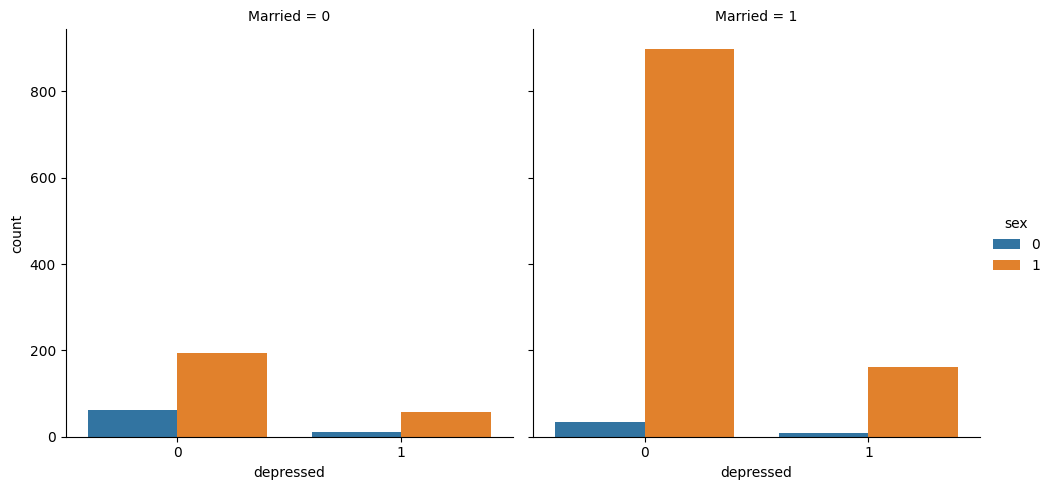

In [64]:
sns.catplot(x='depressed', col='Married', hue='sex',  kind='count', data= data_pd)

Сделав некоторые выводы по этому поводу, мы можем поспешно сказать, что брак помогает избежать депрессии, согласно приведенным выше графикам!. Но помните, что мы имеем дело с несбалансированными данными, большинство людей (>80%) не подвержены депрессии.

In [65]:
#Если мы рассмотрим следующую функцию "no_lasting_investment", то обнаружим несколько строк без значений:
data_pd.no_lasting_investmen.isnull().sum()

20

Мы приступим к заполнению недостающих значений медианой:

In [66]:
data_pd['no_lasting_investmen'].fillna(data_pd['no_lasting_investmen'].median(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_6272\4197272956.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_pd['no_lasting_investmen'].fillna(data_pd['no_lasting_investmen'].median(), inplace=True)


In [67]:
data_pd.no_lasting_investmen.isnull().sum()

0

In [68]:
data_pd['no_lasting_investmen'] = data_pd['no_lasting_investmen'].astype(int)

In [69]:
data_pd = data_pd.drop(columns=['Survey_id'])

Этот набор данных является чистым, для значений отклонений мы использовали среднее значение и дисперсию со следующим соотношением: среда +-2 дисперсии. Переменной, которая имела много отклонений, был возраст. Далее я покажу, как генерировать новые дискретные переменные, чтобы принимать диапазоны, а не значения с большой разницей между ними.

# Логистическая регрессия

In [70]:
X = data_pd
y = data_pd['depressed']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)

In [71]:
log_reg = LogisticRegression(
    class_weight="balanced", # присваивает разные веса классам в зависимости от их размера в обучающей выборке
    random_state=1, 
    max_iter=100, 
    solver="liblinear" # для маленьких наборов
) 
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_valid)

print(accuracy_score(y_valid, y_pred))
print(f1_score(y_valid, y_pred))

0.611731843575419
0.28717948717948716


In [72]:
cm = confusion_matrix(y_valid, y_pred)
print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_valid, y_pred, digits=2))

[[191 108]
 [ 31  28]]
              precision    recall  f1-score   support

           0       0.86      0.64      0.73       299
           1       0.21      0.47      0.29        59

    accuracy                           0.61       358
   macro avg       0.53      0.56      0.51       358
weighted avg       0.75      0.61      0.66       358



In [73]:
data_pd_class_0  = data_pd[data_pd['depressed'] == 0]
data_pd_class_1 = data_pd[data_pd['depressed'] == 1]

In [74]:
data_pd_0_resample = resample(data_pd_class_0, replace=True, n_samples=len(data_pd_class_1))
data_pd_data = pd.concat([data_pd_0_resample, data_pd_class_1])

In [75]:
X = data_pd_data.drop(columns=['depressed'])
y = data_pd_data['depressed']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)

In [76]:
log_reg = LogisticRegression(
    random_state=1, 
    max_iter=100, 
    solver="liblinear" # для маленьких наборов
) 
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_valid)

print(accuracy_score(y_valid, y_pred))
print(f1_score(y_valid, y_pred))

0.4789915966386555
0.38


In [77]:
cm = confusion_matrix(y_valid, y_pred)
print(cm)
# Print the precision and recall, among other metrics
print(classification_report(y_valid, y_pred, digits=2))

[[38 17]
 [45 19]]
              precision    recall  f1-score   support

           0       0.46      0.69      0.55        55
           1       0.53      0.30      0.38        64

    accuracy                           0.48       119
   macro avg       0.49      0.49      0.47       119
weighted avg       0.50      0.48      0.46       119



In [78]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[34 21]
 [35 29]]
F1 score valid: 0.5087719298245614


In [79]:
rf = DecisionTreeClassifier(max_depth=2)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[43 12]
 [43 21]]
F1 score valid: 0.4329896907216495


In [80]:
# sns.pairplot(data_pd_data)